In [ ]:
%env SM_FRAMEWORK=tf.keras
import os
from google.colab.patches import cv2_imshow
import re
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from segmentation_models import Unet



from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping




env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [ ]:
!pip install segmentation_models

     |████████████████████████████████| 50 kB 7.6 MB/s 


In [ ]:
framObjTrain = {'img' : [],
                'mask' : []
                }

framObjVal = {'img' : [],
                'mask' : []
                }


def LoadData(frameObj = None, imgPath = None, maskPath = None, shape=256):
    imgNames = os.listdir(imgPath)
    maskNames = []

    for mem in imgNames:
        maskNames.append(re.sub('\.png', '_L.png', mem))

    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'

    for i in range (len(imgNames)):
        img = plt.imread(imgAddr + imgNames[i])
        mask = plt.imread(maskAddr + maskNames[i])

        img = cv2.resize(img, (shape,shape))
        mask = cv2.resize(mask, (shape, shape))

        frameObj['img'].append(img)
        frameObj['mask'].append(mask)

    return frameObj

In [ ]:
def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if (pool == True):
        p = MaxPool2D((2,2))(x)
        return x, p
    

    else:
        return x

def build_unet(shape, num_classes, dropouts=0.07):
    inputs = Input(shape)

    """ENCODER"""
    x1, p1 = conv_block(inputs, 16, pool=True)
    p1 = Dropout(dropouts)(p1)
    x2, p2 = conv_block(p1, 32, pool=True)
    p2 = Dropout(dropouts)(p2)
    x3, p3 = conv_block(p2, 64, pool=True)
    p3 = Dropout(dropouts)(p3)
    x4, p4 = conv_block(p3, 128, pool=True)
    p4 = Dropout(dropouts)(p4)

    """BRIDGE"""
    b1 = conv_block(p4, 256, pool= True)

    """DECODER"""
    u1 = Conv2DTranspose(128, (3,3), strides=(2,2), padding="same")(b1[0])
    c1 = Concatenate()([u1,x4])
    c1 = Dropout(dropouts)(c1)
    x5 = conv_block(c1, 128, pool=True)

    u2 = Conv2DTranspose(64, (3,3), strides=(2,2), padding="same")(x5[0])
    c2 = Concatenate()([u2,x3])
    c2 = Dropout(dropouts)(c2)
    x6 = conv_block(c2, 64, pool=True)

    u3 = Conv2DTranspose(32, (3,3), strides=(2,2), padding="same")(x6[0])
    c3 = Concatenate()([u3,x2])
    c3 = Dropout(dropouts)(c3)
    x7 = conv_block(c3, 32, pool=True)

    u4 = Conv2DTranspose(16, (3,3), strides=(2,2), padding="same")(x7[0])
    c4 = Concatenate()([u4, x1])
    c4 = Dropout(dropouts)(c4)
    x8 = conv_block(c4, 16, pool=True)

    """OUTPUT LAYER"""

    outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(x8[0])



    return Model(inputs,outputs)

In [ ]:
    """DATASET"""

    framObjTrain = {'img' : [],
                'mask' : []
                }

    framObjVal = {'img' : [],
                'mask' : []
                }
    
    framObjTest = {'img' : [],
                'mask' : []
                }


    framObjTrain = LoadData(framObjTrain, imgPath='/content/drive/MyDrive/CamVid/train', maskPath='/content/drive/MyDrive/CamVid/train_labels', shape=256)
    framObjVal = LoadData(framObjVal, imgPath='/content/drive/MyDrive/CamVid/test', maskPath='/content/drive/MyDrive/CamVid/test_labels', shape=256)
    framObjTest = LoadData(framObjTest, imgPath='/content/drive/MyDrive/CamVid/val', maskPath='/content/drive/MyDrive/CamVid/val_labels', shape = 256)

    
    
    

In [ ]:
    """SEEDING"""
    np.random.seed(42)
    tf.random.set_seed(42)

    """HYPERPARAMETERS"""
    shape = (256, 256, 3)
    num_classes = 3
    lr = 1e-4
    batch_size = 16
    epochs = 200

    """MODEL"""
    model = Unet(backbone_name='resnet101', encoder_weights='imagenet', encoder_freeze=True, activation="softmax", classes =3)
    model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr))

    train_steps = len(framObjTrain['img'])//batch_size
    val_steps = len(framObjVal['img'])//batch_size





    callbacks = [
        ModelCheckpoint("model.h5", verbose=1, save_best_model=True),
        ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=8,verbose=1,mode="max",min_lr=0.0001)
        ]

171180032/171164896 [==============================] - 6s 0us/step


In [ ]:
model.fit(x=np.array(framObjTrain['img']), y=np.array(framObjTrain['mask']),epochs= epochs,callbacks=callbacks,
        validation_data=(np.array(framObjVal['img']), np.array(framObjVal['mask'])),
        validation_steps=val_steps,
        steps_per_epoch=train_steps)                

model.evaluate(np.array(framObjTest['img']), np.array(framObjTest['mask']))

Epoch 1/200
23/23 [==============================] - ETA: 0s - loss: 1.1080
Epoch 1: saving model to model.h5
23/23 [==============================] - 68s 2s/step - loss: 1.1080 - val_loss: 1.1038 - lr: 1.0000e-04
Epoch 2/200
23/23 [==============================] - ETA: 0s - loss: 1.0291
Epoch 2: saving model to model.h5
23/23 [==============================] - 30s 1s/step - loss: 1.0291 - val_loss: 1.1069 - lr: 1.0000e-04
Epoch 3/200
23/23 [==============================] - ETA: 0s - loss: 1.0030
Epoch 3: saving model to model.h5
23/23 [==============================] - 30s 1s/step - loss: 1.0030 - val_loss: 1.1024 - lr: 1.0000e-04
Epoch 4/200
23/23 [==============================] - ETA: 0s - loss: 1.0024
Epoch 4: saving model to model.h5
23/23 [==============================] - 31s 1s/step - loss: 1.0024 - val_loss: 1.0947 - lr: 1.0000e-04
Epoch 5/200
23/23 [==============================] - ETA: 0s - loss: 0.9810
Epoch 5: saving model to model.h5
23/23 [===========================

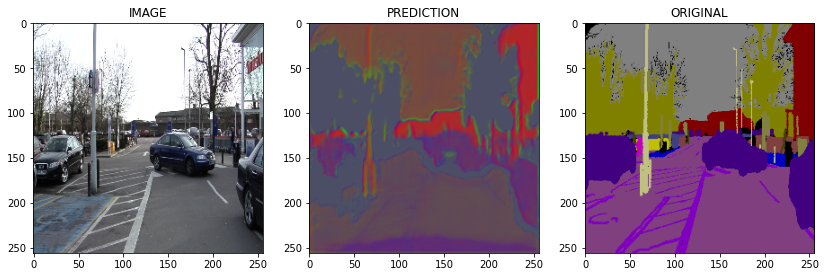

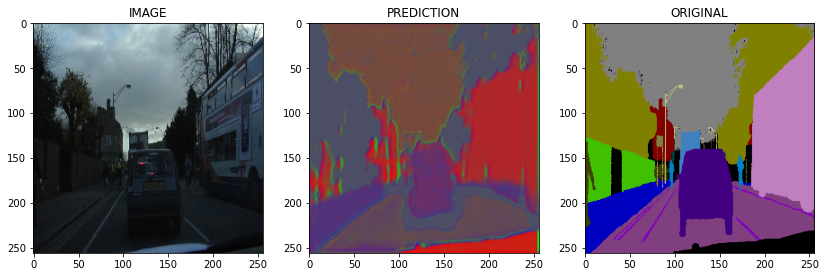

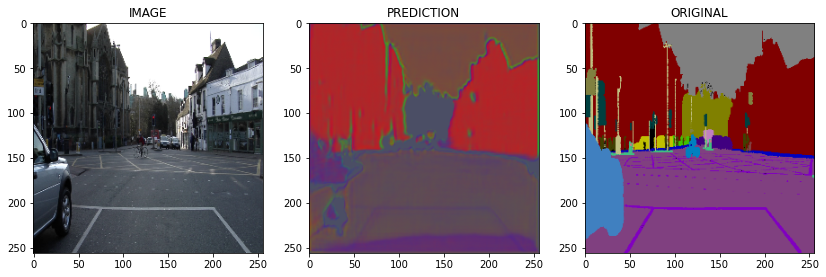

In [ ]:
model = tf.keras.models.load_model("/content/model.h5")
def predict(valMap, model, shape=256):
    img = valMap['img']
    mask = valMap['mask']
    img = img[10:30]
    mask = mask[10:30]
    imgProc = np.array(img)

    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0], predictions[i,:,:,1], predictions[i,:,:,2]))

    return predictions, imgProc, mask

def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(14,14))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("IMAGE")

    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title("PREDICTION")

    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title("ORIGINAL")

    plt.show()

allprediction, actuals, masks = predict(framObjTest, model)

Plotter(actuals[8], allprediction[8], masks[8])
Plotter(actuals[0], allprediction[0], masks[0])
Plotter(actuals[11], allprediction[11], masks[11])

In [ ]:
net = tf.keras.models.load_model("/content/model.h5")
capture = cv2.VideoCapture('/content/testvideo.mp4')
writer = None
resize = (256, 256)
frames = []
while True:
    ret, frame = capture.read()
    if not ret:
        break
    
    
    frame = np.array(cv2.resize(frame, resize))
    frames.append(frame)
    frames = np.asarray(frames) 
    output = net.predict(frames)[0]
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.show()
    key = cv2.waitKey(0) & 0xFF
    if key == ord("q"):
        break


    
capture.release()
cv2.destroyAllWindows()